Minimum Loss: 0.9724745750427246, Minimum LR: 0.008902150854450393


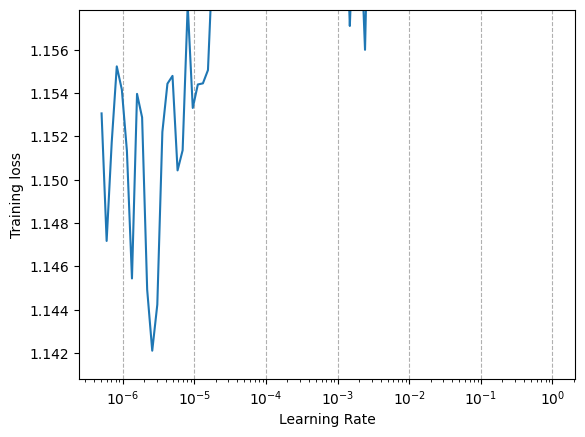

In [12]:
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    MultiplicativeLR,
    OneCycleLR,
    PolynomialLR,
)

import torch
from torch.utils.data import DataLoader
from dataloader import DatasetLoaderClassification
from torch import nn
import loop as lp
import torchvision.transforms.v2 as transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
import matplotlib.pyplot as plt
from loss import FocalLoss

def stack_loss(loss1, loss2):
    def compute_loss(*args, **kwargs):
        return loss1(*args, **kwargs) + 2 * loss2(*args, **kwargs)

    return compute_loss

def plot_recorder(lr_recorder, loss_recorder, beta: float = 0.95, **kwargs) -> None:
    """Display the results of the LR grid search.
    Adapted from https://github.com/frgfm/Holocron/blob/master/holocron/trainer/core.py

    Args:
    ----
        lr_recorder: list of LR values
        loss_recorder: list of loss values
        beta (float, optional): smoothing factor
        **kwargs: keyword arguments from `matplotlib.pyplot.show`
    """
    if len(lr_recorder) != len(loss_recorder) or len(lr_recorder) == 0:
        raise AssertionError("Both `lr_recorder` and `loss_recorder` should have the same length")

    # Exp moving average of loss
    smoothed_losses = []
    avg_loss = 0.0
    for idx, loss in enumerate(loss_recorder):
        avg_loss = beta * avg_loss + (1 - beta) * loss
        smoothed_losses.append(avg_loss / (1 - beta ** (idx + 1)))

    # Properly rescale Y-axis
    data_slice = slice(
        min(len(loss_recorder) // 10, 10),
        # -min(len(loss_recorder) // 20, 5) if len(loss_recorder) >= 20 else len(loss_recorder)
        len(loss_recorder),
    )
    vals = np.array(smoothed_losses[data_slice])
    min_idx = vals.argmin()
    max_val = vals.max() if min_idx is None else vals[: min_idx + 1].max()  # type: ignore[misc]
    delta = max_val - vals[min_idx]

    plt.plot(lr_recorder[data_slice], smoothed_losses[data_slice])
    plt.xscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Training loss")
    plt.ylim(vals[min_idx] - 0.1 * delta, max_val + 0.2 * delta)
    plt.grid(True, linestyle="--", axis="x")
    plt.show(**kwargs)


def record_lr(
    model: torch.nn.Module,
    train_loader: DataLoader,
    batch_transforms,
    optimizer,
    criterion,
    start_lr: float = 1e-7,
    end_lr: float = 1,
    num_it: int = 100,
    amp: bool = False,
):
    """Gridsearch the optimal learning rate for the training.
    Adapted from https://github.com/frgfm/Holocron/blob/master/holocron/trainer/core.py
    """
    if num_it > len(train_loader):
        raise ValueError(
            "the value of `num_it` needs to be lower than the number of available batches"
        )

    model = model.train()
    # Update param groups & LR
    optimizer.defaults["lr"] = start_lr
    for pgroup in optimizer.param_groups:
        pgroup["lr"] = start_lr

    gamma = (end_lr / start_lr) ** (1 / (num_it - 1))
    scheduler = MultiplicativeLR(optimizer, lambda step: gamma)

    lr_recorder = [start_lr * gamma**idx for idx in range(num_it)]
    loss_recorder = []

    if amp:
        scaler = torch.cuda.amp.GradScaler()

    for batch_idx, (images, targets) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            targets = targets.cuda()

        images = batch_transforms(images)

        # Forward, Backward & update
        optimizer.zero_grad()
        if amp:
            with torch.cuda.amp.autocast():
                train_loss = model(images, targets)["loss"]
            scaler.scale(train_loss).backward()
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            # Update the params
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss = criterion(model(images), targets)
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
        # Update LR
        scheduler.step()

        # Record
        if not torch.isfinite(train_loss):
            if batch_idx == 0:
                raise ValueError("loss value is NaN or inf.")
            else:
                break
        loss_recorder.append(train_loss.item())
        # Stop after the number of iterations
        if batch_idx + 1 == num_it:
            break

    return lr_recorder[: len(loss_recorder)], loss_recorder


def main():

    epochs = 20
    lr = 5e-5

    torch.backends.cudnn.benchmark = True

    train_transf = transforms.Compose(
        (
            transforms.PILToTensor(),
            transforms.ToDtype(torch.float32, True),
            transforms.RandomShortestSize(min_size=256, max_size=512),
            transforms.RandomCrop(128),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ),
    )

    val_transf = transforms.Compose(
        (
            transforms.PILToTensor(),
            transforms.ToDtype(torch.float32, True),
            transforms.RandomShortestSize(min_size=256, max_size=512),
            transforms.RandomCrop(128),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ),
    )

    batch_size = 2

    model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
    model.classifier += nn.Sequential(
        nn.Linear(model.classifier.pop(-1).in_features, 5), nn.Softmax(0)
    )
    model = model.cuda()

    loss_fn = loss_fn = stack_loss(nn.BCELoss(), FocalLoss())

    # 5e-6, 0.01
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)

    dataset = DatasetLoaderClassification(split=(0.75, 0.25, 0.0)).from_directory(
        "./ECGs retos/ECGs retos"
    )

    t = dataset.train(train_transf)
    v = dataset.validation(val_transf)

    train_dataloader = DataLoader(
        dataset=t,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
    )

    lrs, losses = record_lr(
        model, train_dataloader, lambda x: x, optimizer, loss_fn, amp=False
    )

    k = min(zip(lrs, losses), key=lambda x: x[1])

    print(f'Minimum Loss: {k[1]}, Minimum LR: {k[0]}')
    plot_recorder(lrs, losses)


if __name__ == "__main__":
    torch.set_float32_matmul_precision("high")
    main()